Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb


load dữ liệu

In [2]:
data = pd.read_csv("archive\heart.csv")  # có thể đọc trực tiếp từ string nếu chưa có file

data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Tiền xử lý dữ liệu

In [3]:
def preprocess_data(df):
    df = df.copy()
    
    # Kiểm tra missing
    if df.isnull().sum().sum() > 0:
        df = df.dropna()
    
    # Chuyển cột phân loại sang số (nếu cần)
    for col in ['sex','cp','fbs','restecg','exang','slope','ca','thal']:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    
    X = df.drop('target', axis=1)
    y = df['target']
    
    return X, y

X, y = preprocess_data(data)
X.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


Chia train/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (717, 13), Test shape: (308, 13)


Train mô hình XGBoost

In [16]:
def train_xgboost(X_train, y_train, X_test, y_test):
    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
    fit_kwargs = {
        'eval_set': [(X_test, y_test)],
        'verbose': False
    }
    try:
        model.fit(X_train, y_train, **fit_kwargs, early_stopping_rounds=20)
    except TypeError:
        model.fit(X_train, y_train, **fit_kwargs)
    return model

model = train_xgboost(X_train, y_train, X_test, y_test)

c:\Users\DELL\miniconda3\envs\pyenv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:16:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Dự đoán & đánh giá

✅ Accuracy: 0.9902597402597403

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       150
           1       1.00      0.98      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



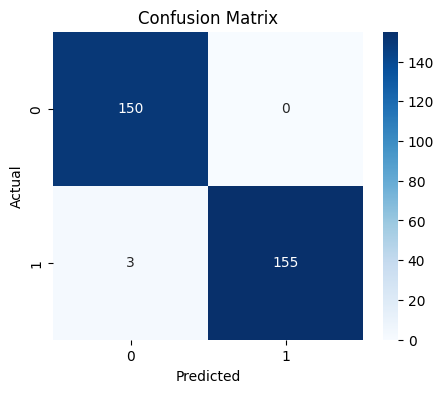

In [18]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Biểu đồ feature importance

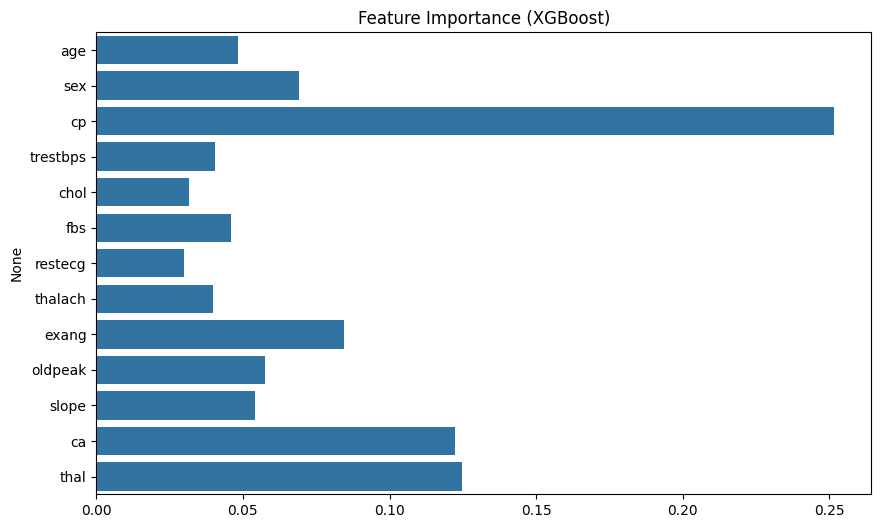

In [19]:
importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance (XGBoost)")
plt.show()

Lưu mô hình

In [21]:
import pickle

# Lưu
with open("xgb_heart_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("✅ Model đã được lưu bằng pickle")

# Load lại
with open("xgb_heart_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
print("✅ Model pickle đã load lại thành công")


✅ Model đã được lưu bằng pickle
✅ Model pickle đã load lại thành công


In [27]:
import pandas as pd
import pickle

# --- Load mô hình đã lưu ---
with open("xgb_heart_model.pkl", "rb") as f:
    model = pickle.load(f)
print("✅ Model đã load thành công!")

# --- Định nghĩa cột dữ liệu ---
columns = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal']

# --- Nhập dữ liệu từ người dùng ---
print("Nhập dữ liệu bệnh nhân (các giá trị phân tách bằng dấu phẩy):")
user_input = input(f"Nhập {len(columns)} giá trị ({', '.join(columns)}):\n")

# --- Chuyển sang DataFrame ---
values = [float(x.strip()) for x in user_input.split(",")]
if len(values) != len(columns):
    raise ValueError(f"Vui lòng nhập đủ {len(columns)} giá trị!")

df_user = pd.DataFrame([values], columns=columns)

# --- Dự đoán ---
prediction = model.predict(df_user)[0]
prob = model.predict_proba(df_user)[0][1]

print("\n🔹 Kết quả dự đoán:")
print(f"Target dự đoán: {prediction} ({'Có nguy cơ bệnh tim' if prediction==1 else 'Không có nguy cơ'})")
print(f"Xác suất nguy cơ: {prob:.2f}")


✅ Model đã load thành công!
Nhập dữ liệu bệnh nhân (các giá trị phân tách bằng dấu phẩy):

🔹 Kết quả dự đoán:
Target dự đoán: 1 (Có nguy cơ bệnh tim)
Xác suất nguy cơ: 0.88
